In [1]:
import torch
import torch_scatter
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils

from torch import Tensor
from typing import Union, Tuple, Optional
from torch_geometric.typing import (OptPairTensor, Adj, Size, NoneType,
                                    OptTensor)

from torch.nn import Parameter, Linear
from torch_sparse import SparseTensor, set_diag
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import remove_self_loops, add_self_loops, softmax

class GNNStack(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, args, emb=False):
        super(GNNStack, self).__init__()
        conv_model = GraphSage
        self.convs = nn.ModuleList()
        self.convs.append(conv_model(input_dim, hidden_dim))
        assert (args.num_layers >= 1), 'Number of layers is not >=1'
        for l in range(args.num_layers-1):
            self.convs.append(conv_model(args.heads * hidden_dim, hidden_dim))

        # post-message-passing
        self.post_mp = nn.Sequential(
            nn.Linear(args.heads * hidden_dim, hidden_dim), nn.Dropout(args.dropout), 
            nn.Linear(hidden_dim, output_dim))

        self.dropout = args.dropout
        self.num_layers = args.num_layers

        self.emb = emb

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
          
        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout)

        x = self.post_mp(x)

        if self.emb == True:
            return x

        return F.log_softmax(x, dim=1)

    def loss(self, pred, label):
        return F.nll_loss(pred, label)

In [2]:
class GraphSage(MessagePassing):
    
    def __init__(self, in_channels, out_channels, normalize = True,
                 bias = False, **kwargs):  
        super(GraphSage, self).__init__(**kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.normalize = normalize

        self.lin_l = None
        self.lin_r = None

        ############################################################################
        # TODO: Your code here! 
        # Define the layers needed for the message and update functions below.
        # self.lin_l is the linear transformation that you apply to embedding 
        #            for central node.
        # self.lin_r is the linear transformation that you apply to aggregated 
        #            message from neighbors.
        # Our implementation is ~2 lines, but don't worry if you deviate from this.
        self.lin_l = nn.Linear(self.in_channels, self.out_channels)
        self.lin_r = nn.Linear(self.in_channels, self.out_channels)

        ############################################################################

        self.reset_parameters()


    def reset_parameters(self):
        self.lin_l.reset_parameters()
        self.lin_r.reset_parameters()

    def forward(self, x, edge_index, size = None):
        """"""

        out = None

        ############################################################################
        # TODO: Your code here! 
        # Implement message passing, as well as any post-processing (our update rule).
        # 1. First call propagate function to conduct the message passing.
        #    1.1 See there for more information: 
        #        https://pytorch-geometric.readthedocs.io/en/latest/notes/create_gnn.html
        #    1.2 We use the same representations for central (x_central) and 
        #        neighbor (x_neighbor) nodes, which means you'll pass x=(x, x) 
        #        to propagate.
        # 2. Update our node embedding with skip connection.
        # 3. If normalize is set, do L-2 normalization (defined in 
        #    torch.nn.functional)
        # Our implementation is ~5 lines, but don't worry if you deviate from this.
        prop = self.propagate(edge_index, x=(x, x), size=size)
        out = self.lin_l(x) + self.lin_r(prop)
        if self.normalize:
            out = F.normalize(out, p=2)
        ############################################################################

        return out

    def message(self, x_j):

        out = None

        ############################################################################
        # TODO: Your code here! 
        # Implement your message function here.
        # Our implementation is ~1 lines, but don't worry if you deviate from this.

        out = x_j
        ############################################################################

        return out

    def aggregate(self, inputs, index, dim_size = None):

        out = None

        # The axis along which to index number of nodes.
        node_dim = self.node_dim

        ############################################################################
        # TODO: Your code here! 
        # Implement your aggregate function here.
        # See here as how to use torch_scatter.scatter: 
        # https://pytorch-scatter.readthedocs.io/en/latest/functions/scatter.html#torch_scatter.scatter
        # Our implementation is ~1 lines, but don't worry if you deviate from this.

        out = torch_scatter.scatter(inputs, index, node_dim, dim_size=dim_size, reduce='mean')
        ############################################################################

        return out

In [3]:
import torch.optim as optim

def build_optimizer(args, params):
    weight_decay = args.weight_decay
    filter_fn = filter(lambda p : p.requires_grad, params)
    if args.opt == 'adam':
        optimizer = optim.Adam(filter_fn, lr=args.lr, weight_decay=weight_decay)
    elif args.opt == 'sgd':
        optimizer = optim.SGD(filter_fn, lr=args.lr, momentum=0.95, weight_decay=weight_decay)
    elif args.opt == 'rmsprop':
        optimizer = optim.RMSprop(filter_fn, lr=args.lr, weight_decay=weight_decay)
    elif args.opt == 'adagrad':
        optimizer = optim.Adagrad(filter_fn, lr=args.lr, weight_decay=weight_decay)
    if args.opt_scheduler == 'none':
        return None, optimizer
    elif args.opt_scheduler == 'step':
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=args.opt_decay_step, gamma=args.opt_decay_rate)
    elif args.opt_scheduler == 'cos':
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.opt_restart)
    return scheduler, optimizer

In [4]:
import time

import networkx as nx
import numpy as np
import torch
import torch.optim as optim

from torch_geometric.datasets import TUDataset
from torch_geometric.datasets import Planetoid
from torch_geometric.data import DataLoader

import torch_geometric.nn as pyg_nn

import matplotlib.pyplot as plt

In [48]:

def train(num_node_features,num_classes,train_mask,args):
    
    #print("Node task. test set size:", np.sum(dataset[0]['train_mask'].numpy()))
    #test_loader = loader = DataLoader(dataset, batch_size=args.batch_size, shuffle=True)

    # build model
    model = GNNStack(num_node_features, args.hidden_dim, num_classes, 
                            args)
    scheduler, opt = build_optimizer(args, model.parameters())

    # train
    losses = []
    test_accs = []
    for epoch in range(args.epochs):
        total_loss = 0
        model.train()
        for batch in loader:
            opt.zero_grad()
            pred = model(batch)
            label = batch.y
            pred = pred[batch.train_mask]
            label = label[batch.train_mask]
            loss = model.loss(pred, label)
            loss.backward()
            opt.step()
            total_loss += loss.item() * batch.num_graphs
        total_loss /= len(loader.dataset)
        losses.append(total_loss)
        test_acc = test(test_loader, model)
        test_accs.append(test_acc)
        if epoch % 1 == 0:
          #test_acc = test(test_loader, model)
          #test_accs.append(test_acc)
          print("Epoch ", epoch, "Loss: ", total_loss, "Test Acc.: ", test_acc)
        #else:
        #  test_accs.append(test_accs[-1])
    return test_accs, losses

def test(loader, model, is_validation=True):
    model.eval()

    correct = 0
    for data in loader:
        with torch.no_grad():
            # max(dim=1) returns values, indices tuple; only need indices
            pred = model(data).max(dim=1)[1]
            label = data.y

        mask = data.val_mask if is_validation else data.test_mask
        # node classification: only evaluate on nodes in test set
        pred = pred[mask]
        label = data.y[mask]
            
        correct += pred.eq(label).sum().item()

    total = 0
    for data in loader.dataset:
        total += torch.sum(data.val_mask if is_validation else data.test_mask).item()
    return correct / total
  
class objectview(object):
    def __init__(self, d):
        self.__dict__ = d

In [6]:
dataset = Planetoid(root='/tmp/cora', name='Cora')
test_loader = loader = DataLoader(dataset, batch_size=32, shuffle=True)
for data in loader:
    print(data)
#args={'model_type': 'GraphSage', 'dataset': 'cora', 'num_layers': 3, 'heads': 2, 
#         'batch_size': 32, 'hidden_dim': 32, 'dropout': 0.5, 'epochs': 100, 
#         'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 
#         'weight_decay': 5e-3, 'lr': 0.01}
args={'model_type': 'GraphSage', 'dataset': 'cora', 'num_layers': 2, 'heads': 1, 
         'batch_size': 32, 'hidden_dim': 32, 'dropout': 0.5, 'epochs': 50, 
         'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 
         'weight_decay': 5e-3, 'lr': 0.01}
args = objectview(args)
test_accs, losses = train(dataset.num_node_features,dataset.num_classes,data.train_mask,args)
print("Maximum accuracy: {0}".format(max(test_accs)))
print("Minimum loss: {0}".format(min(losses)))

/Users/joshem/anaconda3/lib/python3.11/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


DataBatch(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], batch=[2708], ptr=[2])
Epoch  0 Loss:  1.9529750347137451 Test Acc.:  0.188
Epoch  10 Loss:  1.6385999917984009 Test Acc.:  0.452
Epoch  20 Loss:  1.0028141736984253 Test Acc.:  0.61
Epoch  30 Loss:  0.5976952910423279 Test Acc.:  0.638
Epoch  40 Loss:  0.4434676766395569 Test Acc.:  0.688
Epoch  50 Loss:  0.352372407913208 Test Acc.:  0.62
Epoch  60 Loss:  0.22275181114673615 Test Acc.:  0.692
Epoch  70 Loss:  0.17056293785572052 Test Acc.:  0.698
Epoch  80 Loss:  0.1817769855260849 Test Acc.:  0.656
Epoch  90 Loss:  0.24345368146896362 Test Acc.:  0.686
Epoch  100 Loss:  0.21227717399597168 Test Acc.:  0.714
Epoch  110 Loss:  0.20018163323402405 Test Acc.:  0.716
Epoch  120 Loss:  0.1751159280538559 Test Acc.:  0.7
Epoch  130 Loss:  0.18579372763633728 Test Acc.:  0.688
Epoch  140 Loss:  0.18944086134433746 Test Acc.:  0.694
Epoch  150 Loss:  0.2213790863752365 Test Acc.: 

In [7]:
x_dom=data.x
print(x_dom)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


In [8]:
import pandas as pd
import numpy as np

df_data = pd.read_csv('Feature_cora.csv')

df_data.head()

,Unnamed: 0,a_0,b_0,a_1,b_1,a_2,b_2,a_3,b_3,a_4,...,S_5,S_6,In_0,In_1,In_2,In_3,In_4,In_5,In_6,Class
0,0,1,0,155,3,5,0,0,0,4,...,2,1,16,20,20,16,17,12,14,1
1,1,0,0,3,1,0,0,0,0,0,...,7,4,16,18,18,17,15,16,15,1
2,2,0,0,0,0,1,0,1,0,40,...,3,1,10,11,12,10,12,7,8,4
3,3,0,0,0,0,0,0,3,0,14,...,2,5,13,17,19,18,20,14,18,4
4,4,0,0,0,0,0,1,0,0,4,...,2,3,17,17,19,17,20,15,17,4


In [9]:
data_c=df_data.drop(['Unnamed: 0','Class'], axis=1)
data_c.head()

,a_0,b_0,a_1,b_1,a_2,b_2,a_3,b_3,a_4,b_4,...,S_4,S_5,S_6,In_0,In_1,In_2,In_3,In_4,In_5,In_6
0,1,0,155,3,5,0,0,0,4,0,...,3,2,1,16,20,20,16,17,12,14
1,0,0,3,1,0,0,0,0,0,0,...,6,7,4,16,18,18,17,15,16,15
2,0,0,0,0,1,0,1,0,40,0,...,4,3,1,10,11,12,10,12,7,8
3,0,0,0,0,0,0,3,0,14,0,...,8,2,5,13,17,19,18,20,14,18
4,0,0,0,0,0,1,0,0,4,3,...,8,2,3,17,17,19,17,20,15,17


In [10]:
De=data_c.to_numpy()
Fe=np.array(De,dtype="f")

In [11]:
import numpy as np

p_data = open("/Users/joshem/PhD Research/Data/cora/cora.cites")


# Create a list from the data
myls=list(p_data)

# Remove the new line symbole from the list
mylist = [line.rstrip('\n') for line in myls]
#print(mylist)
#print(graph_ind)
#print(graph_level)

p_data.close()

In [12]:
mynode=[]
Edgelist=[]
i=0
for d in mylist:
    d=mylist[i].split("\t")
    mynode.append(int(d[0]))
    mynode.append(int(d[1]))
    Edgelist.append([int(d[0]),int(d[1])])
    i=i+1
#print(mynode)
node_ID1=np.unique(mynode)
node_ID=list(node_ID1)
#print(node_ID)
n=len(node_ID)
print(n)

2708


In [13]:
edgelist=[]
i=0
for d in mylist:
    d=mylist[i].split("\t")
    edgelist.append([node_ID.index(int(d[0])),node_ID.index(int(d[1]))])
    i=i+1
#print(edgelist)

In [31]:
train=[True, False, True, True, False, False, False, False, False, True, False, True, True, True, True, False, True, True, True, True, True, False, True, True, False, True, False, False, False, False, False, True, False, False, True, True, True, True, True, False, True, True, True, True, True, False, True, True, True, False, True, True, True, True, True, True, False, False, False, True, True, True, True, True, False, True, True, True, True, True, False, True, False, True, True, True, False, True, True, True, False, True, True, False, True, True, False, False, True, True, True, True, False, True, True, False, True, True, False, False, False, False, True, True, False, False, False, True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, False, True, False, False, False, True, True, False, True, False, False, True, False, True, True, True, False, False, False, True, False, True, True, False, True, True, True, True, False, False, True, True, True, True, True, True, False, True, True, False, True, True, False, True, True, True, False, False, True, False, False, False, False, True, True, True, False, False, True, True, True, True, True, True, False, True, False, True, True, False, True, True, False, True, True, True, True, True, False, True, True, False, False, True, True, False, False, False, False, True, True, True, False, False, True, True, True, True, False, True, True, True, True, False, False, True, True, False, True, True, False, False, True, True, True, True, True, True, True, False, True, True, True, True, True, False, True, True, True, True, True, False, True, False, True, True, False, True, True, True, False, False, True, False, False, True, True, False, True, True, True, True, False, True, True, True, True, True, False, True, True, True, True, False, True, False, True, False, True, False, True, True, True, True, False, False, True, True, True, True, False, True, True, False, True, False, False, False, True, True, True, True, True, True, True, True, False, False, True, True, False, False, True, False, True, True, False, False, True, True, False, True, True, True, True, False, False, True, False, False, True, True, True, True, True, True, True, True, True, False, True, True, False, True, False, True, True, False, True, True, False, False, True, True, True, True, False, True, True, False, True, True, False, True, False, True, True, False, True, True, True, False, False, False, True, True, True, False, True, True, True, True, True, False, True, False, False, True, False, False, False, True, False, True, False, False, True, False, False, True, True, True, False, False, True, True, True, False, True, True, True, True, True, True, True, False, True, True, False, False, False, False, False, False, False, True, False, False, True, True, True, True, True, True, True, False, True, True, True, True, False, True, True, True, True, True, True, True, True, True, False, False, True, True, True, True, True, True, True, True, False, True, True, True, True, False, True, True, True, True, True, False, True, False, True, True, True, False, True, False, True, True, True, True, True, True, True, True, False, False, True, False, True, True, True, True, False, True, False, True, False, False, False, False, True, False, False, True, False, True, False, True, True, True, True, False, True, True, False, True, False, True, True, True, False, True, True, True, True, True, False, False, True, True, True, False, True, False, True, False, False, True, False, True, True, True, True, False, False, True, True, False, True, True, False, True, False, True, True, True, True, False, True, True, True, True, True, False, False, True, False, False, True, True, True, True, False, True, False, False, True, False, True, True, True, False, True, True, True, False, True, False, False, True, True, False, True, True, True, False, True, True, True, True, False, True, False, False, True, False, True, False, True, True, True, True, True, False, False, False, True, True, True, True, True, True, False, True, True, False, True, False, True, False, False, True, True, False, True, True, False, True, True, True, False, False, True, True, False, True, True, False, True, False, True, True, True, True, True, False, True, True, False, True, True, False, True, True, False, False, True, True, False, True, False, True, True, False, False, True, False, True, True, True, True, False, False, True, False, False, False, True, True, False, True, True, True, True, True, False, True, False, True, True, True, True, True, True, True, True, True, True, True, False, False, False, True, False, True, True, True, True, True, True, True, True, True, False, True, True, False, True, True, False, False, True, True, True, True, False, True, True, True, True, True, True, True, False, False, True, True, False, True, False, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, False, True, True, False, False, True, False, False, True, False, True, False, True, False, True, True, True, True, False, True, True, False, True, True, True, False, True, True, False, False, True, True, True, True, False, True, True, False, True, True, True, False, True, True, False, False, True, True, True, False, True, False, True, False, True, True, False, True, True, False, False, False, True, False, True, True, True, True, False, False, True, True, True, True, False, True, True, False, True, True, True, False, False, True, True, True, False, True, True, True, False, True, False, False, False, True, True, True, True, True, True, True, True, True, False, True, True, False, True, True, True, True, True, True, True, False, False, False, False, True, True, True, True, True, True, False, True, False, True, True, True, False, True, True, True, False, True, True, True, True, True, True, False, False, True, False, True, False, True, True, True, True, True, False, True, True, False, False, True, True, True, True, True, False, False, False, True, True, True, False, False, False, True, True, False, True, True, False, True, False, True, True, True, False, False, False, False, False, True, False, True, True, True, True, True, False, True, True, True, False, False, True, False, True, True, True, True, False, True, True, False, True, True, True, True, True, True, True, False, True, True, True, False, False, True, True, True, False, True, True, False, True, False, True, False, False, True, True, False, False, True, False, True, True, False, False, True, True, True, False, False, True, True, True, True, False, True, True, True, True, True, True, False, False, True, True, True, True, True, False, False, True, True, False, False, True, True, True, True, False, False, True, False, True, False, False, False, True, True, False, False, False, True, True, False, True, False, False, True, True, True, True, True, True, True, True, True, True, False, True, False, False, False, True, True, False, False, True, True, True, False, False, True, True, True, True, True, False, True, True, True, False, True, False, True, False, True, False, True, True, True, False, True, False, True, False, True, True, True, True, True, True, False, True, True, True, False, True, True, True, False, True, False, True, True, True, False, True, True, True, True, True, True, False, False, False, True, True, False, True, False, True, False, True, True, False, False, False, False, True, True, False, True, True, True, False, True, True, False, False, True, False, False, True, True, False, True, True, True, True, False, True, True, True, True, True, False, False, False, True, True, True, True, False, True, True, True, True, False, True, True, True, False, False, False, False, True, False, False, True, False, True, True, False, False, True, False, True, True, True, True, False, True, True, False, True, True, True, False, False, True, False, False, False, True, True, True, True, True, True, False, True, True, True, True, False, False, False, False, True, True, True, False, True, True, True, False, True, False, True, False, False, False, True, True, True, True, True, False, True, True, True, True, True, True, True, False, True, False, True, False, True, True, False, True, True, True, False, True, True, True, True, True, False, True, True, False, False, True, True, False, True, False, True, False, True, False, True, True, False, True, True, False, True, False, False, True, False, False, False, True, True, False, False, True, True, True, False, True, True, False, False, True, True, False, False, True, True, True, True, True, True, True, True, False, True, False, True, False, False, False, True, False, False, False, True, True, False, True, False, False, True, False, True, False, False, True, True, False, True, False, False, False, True, False, False, True, True, False, True, False, False, True, False, True, False, False, False, True, False, False, True, True, False, False, True, False, True, True, True, True, True, False, True, True, False, True, False, False, True, True, False, True, True, True, True, False, False, True, True, False, True, True, True, True, True, True, False, True, True, False, True, True, True, True, False, False, False, False, False, True, True, False, True, True, True, False, True, False, False, True, True, False, False, True, False, True, True, True, True, True, False, True, False, True, True, True, True, True, False, True, True, True, True, False, True, False, True, False, True, False, False, False, True, True, False, True, False, False, True, False, True, False, True, True, True, False, True, True, True, True, True, True, True, False, True, True, False, False, True, True, False, True, False, False, True, False, True, True, True, True, True, False, True, True, True, True, False, True, False, False, False, True, True, False, True, True, True, True, True, False, True, True, True, True, False, False, True, False, True, True, False, False, False, True, False, True, True, False, True, True, True, True, False, True, False, False, True, True, True, True, False, True, True, False, True, False, True, True, True, True, True, True, True, True, False, True, True, True, True, True, False, True, True, False, True, False, True, True, True, True, True, False, False, True, True, True, True, False, True, False, True, False, False, False, False, True, False, True, True, True, False, False, False, False, True, True, False, True, False, False, True, True, True, False, True, False, True, True, True, True, False, True, False, False, True, True, True, True, False, False, False, True, True, True, False, True, False, True, True, False, False, False, True, False, True, False, True, True, True, False, False, False, True, False, False, False, True, False, True, True, False, False, True, True, False, True, False, True, True, True, True, True, False, False, False, True, True, True, True, True, True, False, True, True, True, False, False, False, True, False, True, True, True, True, True, True, True, False, True, False, True, True, True, False, True, False, True, False, False, True, True, False, True, True, True, True, False, True, True, True, True, False, True, False, True, True, False, True, True, False, True, False, True, True, False, False, False, False, True, True, False, True, True, True, False, False, True, False, False, True, False, False, True, False, True, False, False, True, False, True, True, True, True, True, True, True, False, True, True, False, False, True, False, False, True, True, True, False, True, True, False, True, True, True, True, False, False, False, False, False, False, True, False, False, True, False, True, False, False, True, True, False, True, True, False, True, True, False, True, True, True, True, False, False, True, False, True, False, False, True, False, True, True, False, True, True, False, False, True, False, False, True, False, True, True, True, True, False, True, True, True, True, True, True, True, False, False, True, False, False, True, True, False, True, True, False, True, True, False, True, True, True, True, True, False, False, True, True, False, True, True, True, True, False, True, True, True, True, True, False, False, True, True, True, True, True, False, True, True, True, True, True, True, True, True, False, True, True, False, False, True, False, False, False, True, True, False, True, True, False, False, False, True, True, True, True, True, True, True, False, True, False, True, True, False, True, True, False, True, False, True, False, True, True, False, True, False, False, False, False, True, True, True, True, True, True, True, False, True, True, False, True, True, False, False, True, False, True, False, True, True, False, True, True, True, False, False, False, True, True, False, False, True, False, True, True, False, True, True, True, True, True, False, False, True, False, True, True, True, True, True, False, True, True, True, False, False, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, False, False, False, False, True, True, False, False, False, True, True, False, True, False, True, False, False, True, True, True, True, True, True, True, False, True, True, True, True, False, False, True, True, False, True, False, True, False, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, False, False, True, True, False, True, True, True, True, True, True, True, True, True, True, True, True, False, False, False, False, False, False, True, True, False, True, False, True, True, True, False, True, True, True, True, True, True, False, True, False, False, False, True, True, True, True, False, False, True, True, True, False, False, True, False, True, True, False, True, True, False, False, True, True, True, True, True, True, True, False, True, True, True, True, True, True, False, True, True, False, True, False, True, True, False, False, False, True, True, True, True, False, False, False, False, True, True, True, True, True, True, True, True, True, False, False, False, False, True, True, True, False, False, True, True, False, False, False, True, False, False, True, False, False, True, True, False, False, False, True, True, True, False, True, True, False, True, True, True, True, True, True, False, False, False, True, False, True, True, True, False, False, True, True, False, False, True, True, True, False, False, True, True, True, True, True, True, True, True, False, True, True, False, False, False, True, True, True, True, True, True, True, False, True, True, True, False, True, True, True, False, False, True, True, False, True, True, False, False, False, False, True, True, False, False, True, True, False, True, True, False, True, True, True, True, True, True, True, False, True, True, True, False, False, False, True, True, False, True, False, False, False, True, True, False, True, False, True, True, True, True, False, True, True, True, True, False, True, False, True, True, True, True, True, True, True, True, False, True, False, False, True, True, False, True, True, True, True, True, True, True, True, True, False, False, False, True, True, True, True, True, True, False, False, False, False, True, False, True, True, True, False, True, False, False, False, True, False, True, False, True, False, True, False, True, False, True, False, False, False, False, True, False, True, True, False, False, True, False, True, False, True, True, True, False, True, True, False, True, True, True, True, False, True, True, True, True, False, False, True, False, False, True, True, False, False, True, False, False, True, False, True, True, True, True, False, True, True, False, False, False, False, True, False, False, True, False, True, False, True, True, True, True, False, True, True, True, True, True, False, True, False, True, False, True, False, True, True, False, True, True, True, False, True, True, False, False, True, False, False, True, True, False, True, False, True, False, True, False, False, True, False, True, False, False, True, True, False, True, True, False, False, True, True, False, True, False, True, True, True, False, True, True, True, False, True, True, True, True, True, False, True, True, False, True, False, False, False, True, True, True, True, True, True, True, True, False, False, False, True, True, True, True, False, False, False, True, True, True, True, False, False, False, False, True, True, False, True, False, True, True, True, True, True, True, False, False, True, True, False, True, True, False, False, True, False, True, True, True, False, True, True, False, True, True, False, False, True, True, True, True, False, False, False, False, True, False, False, True, False, False, True, True, False, False, True, True, False, False, True, True, False, False, True, True, False, True, False, False, True, True, True, True, False, True, True, True, False, True, True, False, False, True, True, True, True, True, True, False, True, False, True, True, False, True, True, False, True, False, True, True, False, False, True, True, True, True, True, False, False, True, False, True, False, True, True, True, False, True, True, True, False, True, True, True, False, False, False, False, True, False, True, True, False, False, True, True]

In [32]:
test=[]
for j in range(2708):
    if train[j]==True:
        test.append(False)
    else:
        test.append(True)
        j=j+1
        
#print(test)

In [33]:
#val_mask need to be updated
import torch
edgelist=np.array(edgelist)
x = torch.from_numpy(Fe)
edge_index=torch.from_numpy(edgelist)
Class=df_data['Class'].to_numpy()
y=torch.from_numpy(Class)
train_mask=torch.from_numpy(np.array(train))
test_mask=torch.from_numpy(np.array(test))
val_mask=torch.from_numpy(np.array(test))
print(x)

tensor([[  1.,   0., 155.,  ...,  17.,  12.,  14.],
        [  0.,   0.,   3.,  ...,  15.,  16.,  15.],
        [  0.,   0.,   0.,  ...,  12.,   7.,   8.],
        ...,
        [  0.,   0.,   0.,  ...,  15.,  20.,  15.],
        [  0.,   0.,   0.,  ...,  13.,  19.,  12.],
        [  0.,   0.,   0.,  ...,  13.,  18.,  17.]])


In [34]:
print(len(x[0]))

42


In [35]:
import torch
from torch_geometric.data import Data
dataset = Data(x=x, edge_index=edge_index.t().contiguous(),y=y,train_mask=train_mask,test_mask=test_mask,val_mask=val_mask,name='Cora', num_classes=7,num_node_features=len(x[0]))

In [49]:
test_loader = loader = DataLoader([dataset], batch_size=1, shuffle=True)
for data in loader:
    print(data)

DataBatch(x=[2708, 42], edge_index=[2, 5429], y=[2708], train_mask=[2708], test_mask=[2708], val_mask=[2708], name=[1], num_classes=[1], num_node_features=[1], batch=[2708], ptr=[2])


/Users/joshem/anaconda3/lib/python3.11/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [53]:
args={'model_type': 'GraphSage', 'dataset': 'cora', 'num_layers': 2, 'heads': 1, 
         'batch_size': 32, 'hidden_dim': 32, 'dropout': 0.5, 'epochs': 50, 
         'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 
         'weight_decay': 5e-3, 'lr': 0.01}
args = objectview(args)
graphsage, losses = train(dataset.num_node_features,dataset.num_classes,data.train_mask,args)
print("Maximum accuracy: {0}".format(max(graphsage)))
print("Minimum loss: {0}".format(min(losses)))

Epoch  0 Loss:  1.98124361038208 Test Acc.:  0.178
Epoch  1 Loss:  1.9361032247543335 Test Acc.:  0.289
Epoch  2 Loss:  1.8981090784072876 Test Acc.:  0.304
Epoch  3 Loss:  1.8573143482208252 Test Acc.:  0.305
Epoch  4 Loss:  1.8378068208694458 Test Acc.:  0.307
Epoch  5 Loss:  1.820542335510254 Test Acc.:  0.311
Epoch  6 Loss:  1.8134695291519165 Test Acc.:  0.326
Epoch  7 Loss:  1.8036010265350342 Test Acc.:  0.349
Epoch  8 Loss:  1.7783595323562622 Test Acc.:  0.358
Epoch  9 Loss:  1.754127860069275 Test Acc.:  0.389
Epoch  10 Loss:  1.72825288772583 Test Acc.:  0.394
Epoch  11 Loss:  1.7083746194839478 Test Acc.:  0.405
Epoch  12 Loss:  1.6663655042648315 Test Acc.:  0.416
Epoch  13 Loss:  1.6319681406021118 Test Acc.:  0.41
Epoch  14 Loss:  1.5957062244415283 Test Acc.:  0.417
Epoch  15 Loss:  1.548276662826538 Test Acc.:  0.421
Epoch  16 Loss:  1.5120697021484375 Test Acc.:  0.422
Epoch  17 Loss:  1.4683585166931152 Test Acc.:  0.422
Epoch  18 Loss:  1.428261637687683 Test Acc.: 

In [54]:
import torch
from torch_geometric.data import Data
dataset = Data(x=x_dom, edge_index=edge_index.t().contiguous(),y=y,train_mask=train_mask,test_mask=test_mask,val_mask=val_mask,name='Cora', num_classes=7,num_node_features=len(x_dom[0]))

In [55]:
test_loader = loader = DataLoader([dataset], batch_size=1, shuffle=True)
for data in loader:
    print(data)

DataBatch(x=[2708, 1433], edge_index=[2, 5429], y=[2708], train_mask=[2708], test_mask=[2708], val_mask=[2708], name=[1], num_classes=[1], num_node_features=[1], batch=[2708], ptr=[2])


In [59]:
args={'model_type': 'GraphSage', 'dataset': 'cora', 'num_layers': 2, 'heads': 1, 
         'batch_size': 32, 'hidden_dim': 32, 'dropout': 0.5, 'epochs': 50, 
         'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 
         'weight_decay': 5e-3, 'lr': 0.01}
args = objectview(args)
graphsage_dom, losses = train(dataset.num_node_features,dataset.num_classes,data.train_mask,args)
print("Maximum accuracy: {0}".format(max(graphsage_dom)))
print("Minimum loss: {0}".format(min(losses)))

Epoch  0 Loss:  1.9527794122695923 Test Acc.:  0.29
Epoch  1 Loss:  1.919385313987732 Test Acc.:  0.304
Epoch  2 Loss:  1.8906400203704834 Test Acc.:  0.304
Epoch  3 Loss:  1.869658350944519 Test Acc.:  0.304
Epoch  4 Loss:  1.847719430923462 Test Acc.:  0.304
Epoch  5 Loss:  1.82537841796875 Test Acc.:  0.304
Epoch  6 Loss:  1.8125956058502197 Test Acc.:  0.304
Epoch  7 Loss:  1.7964468002319336 Test Acc.:  0.304
Epoch  8 Loss:  1.745382308959961 Test Acc.:  0.304
Epoch  9 Loss:  1.7100577354431152 Test Acc.:  0.304
Epoch  10 Loss:  1.6747041940689087 Test Acc.:  0.305
Epoch  11 Loss:  1.6225261688232422 Test Acc.:  0.319
Epoch  12 Loss:  1.575866937637329 Test Acc.:  0.344
Epoch  13 Loss:  1.533268928527832 Test Acc.:  0.343
Epoch  14 Loss:  1.472989559173584 Test Acc.:  0.383
Epoch  15 Loss:  1.4168511629104614 Test Acc.:  0.412
Epoch  16 Loss:  1.3825689554214478 Test Acc.:  0.425
Epoch  17 Loss:  1.3076488971710205 Test Acc.:  0.443
Epoch  18 Loss:  1.268257975578308 Test Acc.:  0

<function matplotlib.pyplot.show(close=None, block=None)>

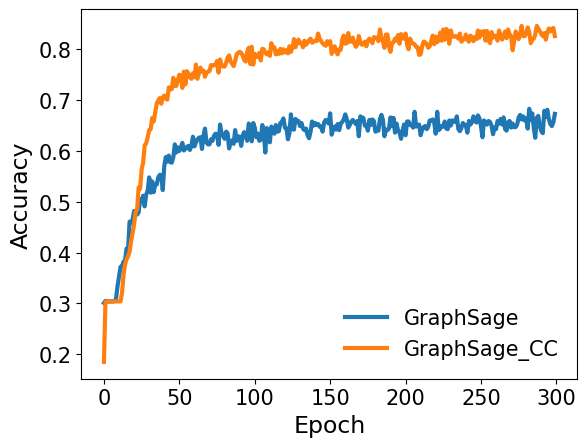

In [47]:



plt.plot(graphsage_dom,linewidth=3,label='GraphSage')
plt.plot(graphsage,linewidth=3,label='GraphSage_CC')
#plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.legend()
plt.xlabel("Epoch",fontsize = 17)
plt.ylabel("Accuracy",fontsize = 17)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
#plt.ylim(0,1)
#plt.legend(["blue", "green"], loc="lower right")
plt.legend(loc="lower right",frameon=False,fontsize = 15)
#for pos in ['right', 'top']: 
    #plt.gca().spines[pos].set_visible(False)
plt.savefig("CC_GraphSage.pdf",bbox_inches="tight")
plt.show

In [ ]:
plt.plot(graphsage_dom,label='GraphSage')
plt.plot(graphsage,label='CC_GraphSage')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.savefig("CC_GraphSage.pdf")
plt.show